This notebook identifies the images whose predictions are furthest away from the truth, for each model.

In [1]:
import numpy as np
from tensorflow import keras
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
modelNames = ("tuned2", "custom3", "tuned3", "tuned5")
modelNames = ("custom3", "tuned3") # not interested in tuned2 or tuned5


#load dataset from directory
image_size = (128, 128)
batch_size = 32
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "tfData-testing",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    shuffle = True,
    color_mode="grayscale"
)

Found 4401 files belonging to 2 classes.


In [3]:
# When given a list of models, this function returns the one which has the lowest loss on the testing dataset, along with its loss, the average loss across all models, and the standard deviation of that average
def findBestModel(models):
    i = 1
    scores = {}
    METRICS = [
          #keras.metrics.TruePositives(name='tp', thresholds=threshold),
          #keras.metrics.FalsePositives(name='fp', thresholds=threshold),
          #keras.metrics.TrueNegatives(name='tn',thresholds=threshold),
          #keras.metrics.FalseNegatives(name='fn',thresholds=threshold), 
          #keras.metrics.BinaryAccuracy(name='accuracy',threshold=threshold),
          keras.metrics.Precision(name='precision',thresholds=.5),
          keras.metrics.Recall(name='recall',thresholds=.5),
          #tfa.metrics.FBetaScore(name="fbeta", num_classes=1,beta=float(2),average='macro')
          #keras.metrics.SpecificityAtSensitivity(sensitivity=.95, name='SensAt95',threshold=threshold)
          #keras.metrics.AUC(name='auc'),
          #keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
        ]
    
    
    for model in models:
        model.compile(
            optimizer=keras.optimizers.Adam(1e-3),
            loss="binary_crossentropy",
            metrics=METRICS,
        )
        # determine the loss, recall, and precision for each model, and store it in scores dict
        qual = (model.evaluate(test_ds))
        scores[qual[0]] = i
        i+=1
        
    
    losses = list(scores.keys())
    bestLoss = min(losses)
    bestModel = models[scores[bestLoss]-1]
    avgLoss = np.mean(losses)
    stdLoss = np.std(losses)
    
    return bestModel, bestLoss, avgLoss, stdLoss

In [4]:
# find the best of the six models of each of the four architectures

bestModels = {}
for modelName in modelNames:
    models = []
    for i in np.arange(1,6+1):
        model = tf.keras.models.load_model("modelDirectory-%s-%s" % (modelName, i))
        models.append(model)
    
    bestModel, _, _, _ = findBestModel(models)
    print("\n")
    
    bestModels[modelName] = bestModel

138/138 [==============================] - 6s 40ms/step - loss: 0.0418 - precision: 0.8910 - recall: 0.7710


138/138 [==============================] - 5s 33ms/step - loss: 0.0515 - precision: 0.9136 - recall: 0.9314




In [5]:
# re-shape the test dataset into a list of image arrays and labels

%%time
rows = []
for row in test_ds.unbatch().as_numpy_iterator():
    rows.append(row)

CPU times: total: 10.1 s
Wall time: 4.37 s


In [6]:
# finds the confidence level of the best model on each of the 4400 images

%%time
predsdict = {}
for (modelName, model) in bestModels.items():
    preds = {"index":[], "pred": [], "label":[]}
    
    
    #for image in the dataset, 
    for i in range(len(rows)):
        arr = rows[i][0]
        label = rows[i][1]
        preds["index"].append(i)
        preds["pred"].append(model.predict(np.expand_dims(arr, axis=0))) # adds the colour axis, as the model expects colour channel
        preds["label"].append(label)
        
        #progress bar
        if str(i)[-2:] == "00":
            print(modelName, i)
    
    preds = pd.DataFrame(preds)
    predsdict[modelName] = preds

custom3 100
custom3 200
custom3 300
custom3 400
custom3 500
custom3 600
custom3 700
custom3 800
custom3 900
custom3 1000
custom3 1100
custom3 1200
custom3 1300
custom3 1400
custom3 1500
custom3 1600
custom3 1700
custom3 1800
custom3 1900
custom3 2000
custom3 2100
custom3 2200
custom3 2300
custom3 2400
custom3 2500
custom3 2600
custom3 2700
custom3 2800
custom3 2900
custom3 3000
custom3 3100
custom3 3200
custom3 3300
custom3 3400
custom3 3500
custom3 3600
custom3 3700
custom3 3800
custom3 3900
custom3 4000
custom3 4100
custom3 4200
custom3 4300
custom3 4400
tuned3 100
tuned3 200
tuned3 300
tuned3 400
tuned3 500
tuned3 600
tuned3 700
tuned3 800
tuned3 900
tuned3 1000
tuned3 1100
tuned3 1200
tuned3 1300
tuned3 1400
tuned3 1500
tuned3 1600
tuned3 1700
tuned3 1800
tuned3 1900
tuned3 2000
tuned3 2100
tuned3 2200
tuned3 2300
tuned3 2400
tuned3 2500
tuned3 2600
tuned3 2700
tuned3 2800
tuned3 2900
tuned3 3000
tuned3 3100
tuned3 3200
tuned3 3300
tuned3 3400
tuned3 3500
tuned3 3600
tuned3 3700
tu

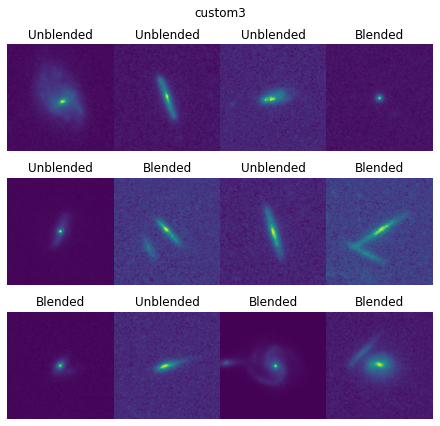

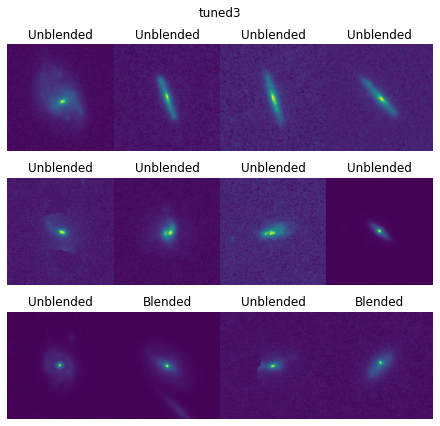

In [23]:
# for each model, and its associated arrays, labels, and predictions, find the twelve images for which there is the greatest discrepancy between the label and the prediction
for (modelName, preds) in predsdict.items():
    plt.figure(figsize = (8,6.5))

    
    preds["uncert"] = [1 - abs(row["pred"] - row["label"]) for (index,row) in preds.iterrows()] # metric for how far away prediction is from label
    preds = preds.sort_values("uncert") # order from worst-to-best
    preds=preds.head(12) #select worst 12
    
    i = 0
    
    for index in preds["index"]:
        ax = plt.subplot(3,4, i + 1)
        ax.imshow(rows[index][0])
        
        if rows[index][1] == 0:
            plt.title("Blended")
        else:
            plt.title("Unblended")
            
        plt.axis("off")
        i+=1
        
        
    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=-0.25, 
                        hspace=0.25)
    plt.suptitle(modelName)
    
    plt.savefig('worstFit-%s.png' % modelName, bbox_inches='tight', dpi=300)